In [1]:
'''
the cat sat on the mat
RNN 계열  : 왼쪽->오른쪽  멀리떨어진 단어들은 서로 영향을 주고 받기 어려움

The cat that the boy who lived here adopted is sleeping

cat VS sleeping

self-attention
Q : 찾고 싶은 정보
K : 가진 정보
V : 최종 전달할 정보

비교대상       유사도            의미
cat vs the     낮음            the 의미없음
cat vs cat     높음            자기자신
cat vs sat     중간            동사와 연결
cat vs on      낮음            on 전치사...
cat vs mat     낮음            의미적으로 멀다

softmax로 중요도 확률처럼 변경  유사도를 가중치로 변환
단어        가중치
the          0.05
cat           0.6
sat           0.3
mat          0.05

cat이 보는 시점은
Query(cat) -> compare with -> key(the) ->key(cat) ->key(sat)

가중치
the : 01   cat:  0.7   sat : 0.2
출력 : 0.1*value(the) + .....

RNN 순차처리
self-attention  병렬처리

다중의미처리
river bank   river를 강하게 참조
bank loan    loan을 강하게 참조
'''

'\nthe cat sat on the mat\nRNN 계열  : 왼쪽->오른쪽  멀리떨어진 단어들은 서로 영향을 주고 받기 어려움\n\nThe cat that the boy who lived here adopted is sleeping\n\ncat VS sleeping\n\nself-attention\nQ : 찾고 싶은 정보\nK : 가진 정보\nV : 최종 전달할 정보\n\n비교대상       유사도            의미\ncat vs the     낮음            the 의미없음\ncat vs cat     높음            자기자신\ncat vs sat     중간            동사와 연결\ncat vs on      낮음            on 전치사...\ncat vs mat     낮음            의미적으로 멀다\n\nsoftmax로 중요도 확률처럼 변경  유사도를 가중치로 변환\n단어        가중치\nthe          0.05\ncat           0.6\nsat           0.3\nmat          0.05\n\ncat이 보는 시점은\nQuery(cat) -> compare with -> key(the) ->key(cat) ->key(sat)\n\n가중치\nthe : 01   cat:  0.7   sat : 0.2\n출력 : 0.1*value(the) + .....\n\nRNN 순차처리\nself-attention  병렬처리\n\n다중의미처리\nriver bank   river를 강하게 참조\nbank loan    loan을 강하게 참조\n'

Text(0, 0.5, 'query')

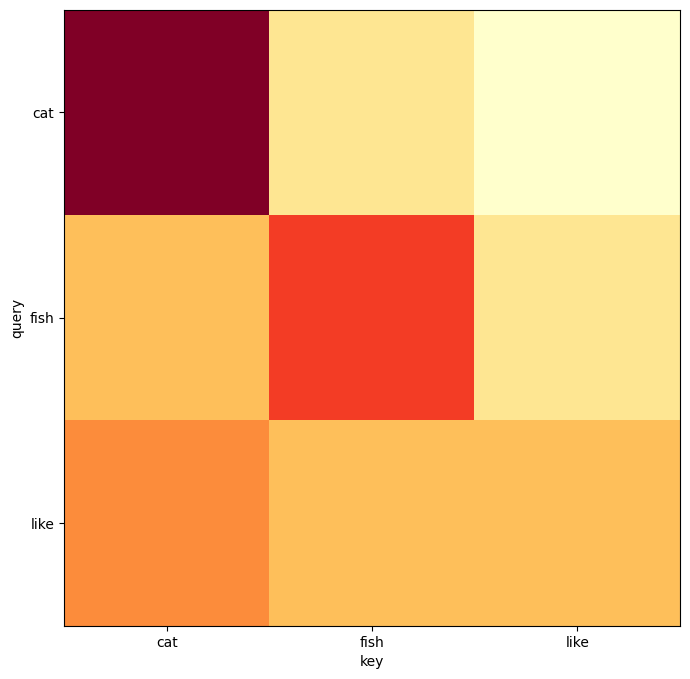

In [2]:
# self-attention 시각화
import numpy as np
import matplotlib.pyplot as plt

words = ['cat','fish','like']  # 고양이가 생선을 좋아한다
# 가상의 attention 가중치
# 각 행은 해당 단어가 다른단어들에게 주목하는 정도
attention_weight = np.array([
    [0.7,0.2,0.1],  # 고양이는 자가자신에게 가장 높은 가중치
    [0.3,0.5,0.2],  #
    [0.4,0.3,0.3]
])

fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(attention_weight, cmap='YlOrRd')

ax.set_xticks(range(len(words)))
ax.set_yticks(range(len(words)))
ax.set_xticklabels(words)
ax.set_yticklabels(words)

ax.set_xlabel('key')
ax.set_ylabel('query')


In [3]:
# Beam Search
# 문장을 생성할때 다음에 나올단어는 수천~수만개가 될수 있는데. 이걸 경우의수로 따지면..... X
# 상위 N개의 후보만 유지  , N을 beam size
# beam size = 1 매번 가장 좋은것만 선택(Greedy)
# beam size = 4 4개의 가능성을 동시에 탐색

In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import time
MODEL_NAME = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

text = """summarize: The Amazon rainforest is the world's largest tropical rainforest.
  It covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries.
  The Amazon is home to millions of species of plants and animals, many of which are found nowhere else on Earth.
  However, deforestation poses a significant threat to this vital ecosystem."""

print('원본 : ')
print(text.replace('summarize:',''))
inputs = tokenizer(text, return_tensors='pt',max_length=512,truncation=True).to(device)
# 다양한 beam size 실험
beam_sizes = [1,2,4,8]
results = []
for num_beams in beam_sizes:
  print(f'beam size : {num_beams}')
  start_time = time.time()
  outputs = model.generate(
      **inputs,
      num_beams = num_beams,
      max_length=60,
      min_length=20,
      early_stopping = True,
      no_repeat_ngram_size = 3,
      num_return_sequences=1
  )
  elapsed_time = time.time() - start_time
  summary = tokenizer.decode(outputs[0],skip_special_tokens=True)
  results.append((num_beams,summary,elapsed_time))

c:\Users\31799\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


원본 : 
 The Amazon rainforest is the world's largest tropical rainforest.
  It covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries.
  The Amazon is home to millions of species of plants and animals, many of which are found nowhere else on Earth.
  However, deforestation poses a significant threat to this vital ecosystem.
beam size : 1
beam size : 2
beam size : 4
beam size : 8


In [5]:
for num_beams,summary,elapsed_time in results:
  print(f'측정시간 : {elapsed_time}')
  print(f'beam size : {num_beams}')
  print(summary)
  print()

# Beam = 1(Greedy)  실시간 시스템
# Beam = 4~5  품질과 속도의 균형( 가장 일반적)
# Beam = 8~10  최고품질이 필요한 경우(논문,공식문서)
# Beam 이 크다고 좋지 않다.. why 과도한 탐색  일반화 성능 이 떨어진다. 즉. 과적합

측정시간 : 0.47363924980163574
beam size : 1
the amazon rainforest covers much of northwestern Brazil. it extends into Colombia, Peru and other South american countries.

측정시간 : 0.4860386848449707
beam size : 2
the amazon rainforest covers much of northwestern Brazil. it extends into Colombia, Peru and other south american countries.

측정시간 : 0.6215677261352539
beam size : 4
the amazon rainforest covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries. deforestation poses a significant threat to this vital ecosystem.

측정시간 : 0.7594821453094482
beam size : 8
the amazon rainforest covers much of northwestern Brazil. it extends into Colombia, Peru and other south american countries.



In [6]:
'''
ROUGE 메트릭
문서을 요약했는데 어떻게 품질을 측정
겹침정도를 측정
ROUGE-1 1개단어 단위
  정답 : 고양이가 생선을 먹었다
  생성 : 고양이가 물고기를 먹었다
  겹침 : 고양이가, 먹었다.  2 / 4 = 0.5
ROUGE-2 2개단어단위 : 순서도 고려
ROUGE-L : 가장 긴 공통 부분수열(순서는 유지하지만 연속적이지 않아도 됨)

단점 : 의미는 같지만 다른표현을 쓰면 점수가 낮다
  자동차 vs 차량 겹침없음으로 판단
'''

'\nROUGE 메트릭\n문서을 요약했는데 어떻게 품질을 측정\n겹침정도를 측정\nROUGE-1 1개단어 단위\n  정답 : 고양이가 생선을 먹었다\n  생성 : 고양이가 물고기를 먹었다\n  겹침 : 고양이가, 먹었다.  2 / 4 = 0.5\nROUGE-2 2개단어단위 : 순서도 고려\nROUGE-L : 가장 긴 공통 부분수열(순서는 유지하지만 연속적이지 않아도 됨)\n\n단점 : 의미는 같지만 다른표현을 쓰면 점수가 낮다\n  자동차 vs 차량 겹침없음으로 판단\n'

In [7]:
# 토크나이져

In [10]:
# 배치처리, 데이터 콜레이터(배치를 만들때 길이를 맞춰주는 작업)
# 효율적인 데이터 처리 방법
from transformers import AutoTokenizer, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM
import torch
import time
# AutoModelForSeq2SeqLM : 입력을 받아서 다른 텍스트 생성하는 seq2seq 모델을 자동로드
# Encoder-Decoder 모델을 자동으로 
# T5, BART, MarianMT 등
# 번역/요약/QA/문장변환 입력->출력

# DataCollatorForSeq2Seq
# seq2seq 학습시 배치단위로 패딩-정렬-라벨 시프트 등을 자동으로 처리하는 데이터 정렬 도구
# 배치생성 - 길이다른 문장들을 동일길이로 패딩
# 라벨 시프트 - 라벨을  디코더 입력으로 사용 (teacher forcing에 필요한 작업)
# DataLoader와 함께 사용
MODEL_NAME = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval()

texts = [
    "summarize: The cat sat on the mat.",
    "summarize: Python is a popular programming language.",
    "summarize: Machine learning is a subset of artificial intelligence.",
    "summarize: The weather is nice today.",
    "summarize: I love reading books in my free time.",
    "summarize: Coffee is one of the most popular beverages worldwide.",
    "summarize: Regular exercise is important for health.",
    "summarize: The Internet has changed how we communicate.",
]

# 개별 처리 VS 배치처리
start_time = time.time()
results_individual = []
with torch.no_grad():
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True).to(device)
        outputs = model.generate(**inputs, max_length=60, min_length=20, early_stopping=True)
        summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
        results_individual.append(summary)
elapsed_individual = time.time() - start_time
print(f'개별처리 시간 : {elapsed_individual}')
print(f'문장당 처리시간 : {elapsed_individual/len(texts)}')

개별처리 시간 : 2.5683114528656006
문장당 처리시간 : 0.3210389316082001


In [11]:
# 배치처리
start_time = time.time()
result_batch = []
outputs = model.generate(**inputs, max_length=60, min_length=20, early_stopping=True)
for output in outputs:
    summary = tokenizer.decode(output, skip_special_tokens=True)
    result_batch.append(summary)
elapsed_batch = time.time() - start_time
print(f'배치처리 시간 : {elapsed_batch}')
print(f'문장당 처리시간 : {elapsed_batch/len(texts)}')

배치처리 시간 : 0.32247424125671387
문장당 처리시간 : 0.04030928015708923


In [14]:
# 데이터콜레이터
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding=True)
tokenized = []
for text in texts:
    tokens = tokenizer(text,truncation=True)
    tokenized.append(tokens)
batch = data_collator(tokenized)
print(batch)

{'input_ids': tensor([[21603,    10,    37,  1712,     3,     7,   144,    30,     8,  6928,
             5,     1,     0,     0],
        [21603,    10, 20737,    19,     3,     9,  1012,  6020,  1612,     5,
             1,     0,     0,     0],
        [21603,    10,  5879,  1036,    19,     3,     9,   769,  2244,    13,
          7353,  6123,     5,     1],
        [21603,    10,    37,  1969,    19,  1245,   469,     5,     1,     0,
             0,     0,     0,     0],
        [21603,    10,    27,   333,  1183,  1335,    16,    82,   339,    97,
             5,     1,     0,     0],
        [21603,    10, 10429,    19,    80,    13,     8,   167,  1012, 18928,
          4388,     5,     1,     0],
        [21603,    10, 17116,  2510,    19,   359,    21,   533,     5,     1,
             0,     0,     0,     0],
        [21603,    10,    37,  1284,    65,  2130,   149,    62,  4521,     5,
             1,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 